In [62]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, classification_report, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc

import wordcloud
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.naive_bayes import MultinomialNB


#metrics


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
orig_df = pd.read_csv("fake_job_postings.csv")
orig_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [10]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
department             6333 non-null object
salary_range           2868 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
benefits               10670 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(13)
memory usage: 2.5+ MB


## Data Imbalanceness

In [11]:
orig_df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

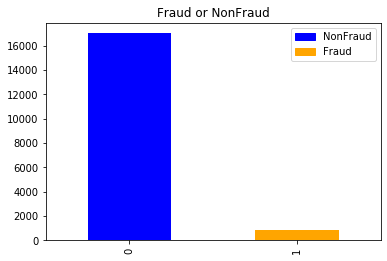

In [12]:
orig_df.fraudulent.value_counts().plot.bar(color=('Blue','Orange'))
plt.title('Fraud or NonFraud')
colors = {'NonFraud':'Blue', 'Fraud':'Orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

## Creating Feature--Feature Engineering

In [13]:
orig_df['location'] = orig_df['location'].fillna('other')
orig_df['country'] = orig_df['location'].apply(lambda x: x.split(',')[0])

In [14]:
orig_df['is_company_profile'] =orig_df['company_profile']
orig_df['is_company_profile'].loc[~orig_df['is_company_profile'].isnull()] = 1
orig_df['is_company_profile'].loc[orig_df['is_company_profile'].isnull()] = 0

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
orig_df['company_profile'] = orig_df['company_profile'].fillna('NotAvailable')

In [16]:
orig_df['company_profile_length'] = orig_df['company_profile'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
orig_df['is_company_profile_short'] = orig_df['company_profile_length'].apply(lambda x : 0 if (x > 10) else 1)

In [17]:
orig_df['is_company_profile_long'] = orig_df['company_profile_length'].apply(lambda x : 1 if (x > 100) else 0)

In [18]:
## Replace null values with notavailable
orig_df['description'] = orig_df['description'].fillna('NotAvailable')

In [19]:
orig_df['company_description_length'] = orig_df['description'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
orig_df['is_company_description_short'] = orig_df['company_description_length'].apply(lambda x : 1 if (x > 40) else 0)

In [20]:
orig_df['is_company_description_long'] = orig_df['company_description_length'].apply(lambda x : 1 if (x > 100) else 0)

In [21]:
orig_df['requirements'] = orig_df['requirements'].fillna('NotAvailable')

In [22]:
orig_df['requirements_length'] = orig_df['requirements'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
orig_df['is_company_requirements_short'] = orig_df['requirements_length'].apply(lambda x : 0 if (x > 10) else 1)

In [23]:
orig_df['money_in_title'] = orig_df['title'].apply(lambda x: 1 if('money' in x) else 0)

In [24]:
orig_df['money_in_description'] = orig_df['description'].apply(lambda x: 1 if('money' in x) else 0)

In [25]:
orig_df['US_or_not'] = orig_df['country'].apply(lambda x: 1 if('US' in x) else 0)

In [26]:
lower_education_list = ['High School or equivalent','Some High School Coursework','Some College Coursework Completed','Unspecified','Vocational']
orig_df['lower_education'] = orig_df['required_education'].apply(lambda x: 1 if(x in lower_education_list) else 0)

In [27]:
prompts_external_list = ['visit here', 'apply here', 'apply at', 'send resume', 'apply online','click here','send','apply', 'url']
orig_df['prompts_external_application'] = orig_df['description'].apply(lambda x: x.lower())
orig_df['prompts_external_application'] = orig_df['prompts_external_application'].apply(lambda x: 1 if any(i in x for i in prompts_external_list) else 0)

In [28]:
spamword_list = ['free', 'earn', 'fun', 'guarantee', 'weekend', 'home', 'easy', 'incentives', 'week', 'incentive', 'commission', 'flexible', 'cash', 'income', 'no experience', 'online']
orig_df['spamword_list'] = orig_df['description'].apply(lambda x: x.lower())
orig_df['spamword_list'] = orig_df['spamword_list'].apply(lambda x: 1 if any(i in x for i in spamword_list) else 0)

## Lets Visualize our developed features
#### Its necessary to balanced our data for feature visulization

In [29]:
Fraud_Posting = orig_df[orig_df['fraudulent']==1]
SampledNonFraud_Posting = orig_df[orig_df['fraudulent']==0].sample(n=866, random_state=1)

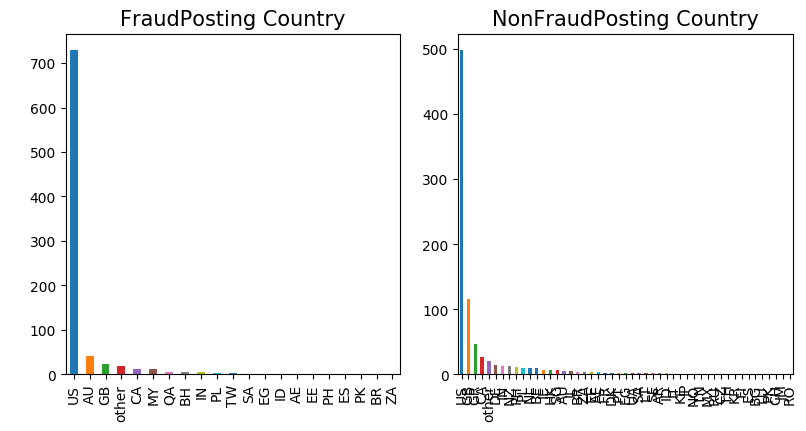

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['country'].value_counts().plot.bar(ax=axes[0])
SampledNonFraud_Posting['country'].value_counts().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPosting Country', fontsize=15)
axes[1].set_title('NonFraudPosting Country', fontsize=15)
plt.show()

As you can see that most fraud jobs are from US. 

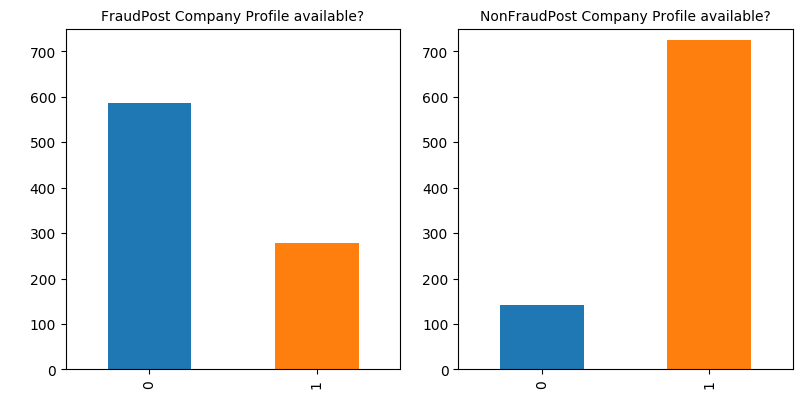

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_profile'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_profile'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPost Company Profile available?', fontsize=10)
axes[1].set_title('NonFraudPost Company Profile available?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])


plt.show()

As you can see that most fraud jobs do not have company profile

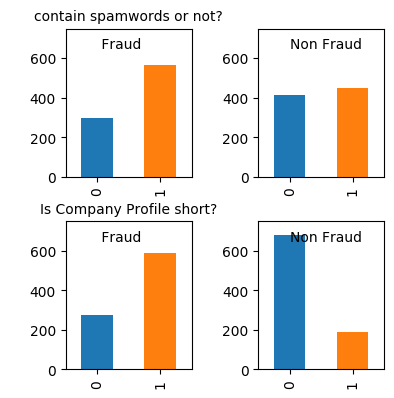

In [32]:
fig, axes = plt.subplots(nrows = 2,ncols=2, figsize=(4, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['spamword_list'].value_counts().sort_index().plot.bar(ax=axes[0][0])
SampledNonFraud_Posting['spamword_list'].value_counts().sort_index().plot.bar(ax=axes[0][1])
axes[0][0].set_ylabel(' ')
axes[0][1].set_ylabel(' ')

axes[0][0].set_title('contain spamwords or not?', fontsize=10)
axes[0][0].text(0,650, " Fraud")
axes[0][0].set_ylim([0, 750])
axes[0][1].set_ylim([0, 750])
axes[0][1].text(0,650, "Non Fraud")

Fraud_Posting['is_company_profile_short'].value_counts().sort_index().plot.bar(ax=axes[1][0])
SampledNonFraud_Posting['is_company_profile_short'].value_counts().sort_index().plot.bar(ax=axes[1][1])

axes[1][0].set_ylabel(' ')
axes[1][1].set_ylabel(' ')

axes[1][0].set_title('Is Company Profile short?', fontsize=10)
axes[1][0].text(0,650, " Fraud")
axes[1][0].set_ylim([0, 750])
axes[1][1].set_ylim([0, 750])
axes[1][1].text(0,650, "Non Fraud")

plt.show()

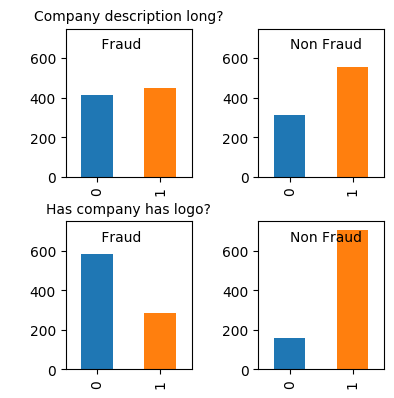

In [33]:
fig, axes = plt.subplots(nrows = 2,ncols=2, figsize=(4, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_description_long'].value_counts().sort_index().plot.bar(ax=axes[0][0])
SampledNonFraud_Posting['is_company_description_long'].value_counts().sort_index().plot.bar(ax=axes[0][1])

axes[0][0].set_ylabel(' ')
axes[0][1].set_ylabel(' ')

axes[0][0].set_title('Company description long?', fontsize=10)
axes[0][0].text(0,650, " Fraud")
axes[0][0].set_ylim([0, 750])
axes[0][1].set_ylim([0, 750])
axes[0][1].text(0,650, "Non Fraud")

Fraud_Posting['has_company_logo'].value_counts().sort_index().plot.bar(ax=axes[1][0])
SampledNonFraud_Posting['has_company_logo'].value_counts().sort_index().plot.bar(ax=axes[1][1])

axes[1][0].set_ylabel(' ')
axes[1][1].set_ylabel(' ')

axes[1][0].set_title('Has company has logo?', fontsize=10)
axes[1][0].text(0,650, " Fraud")
axes[1][0].set_ylim([0, 750])
axes[1][1].set_ylim([0, 750])
axes[1][1].text(0,650, "Non Fraud")

plt.show()

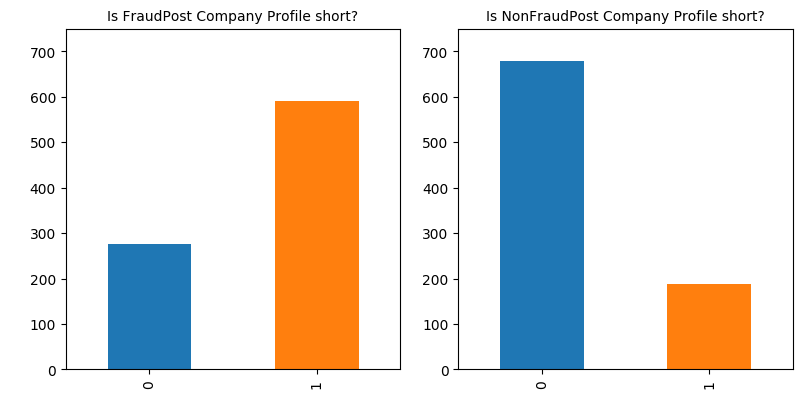

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_profile_short'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_profile_short'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Is FraudPost Company Profile short?', fontsize=10)
axes[1].set_title('Is NonFraudPost Company Profile short?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])
plt.show()

As you can see that most fraud jobs have short company profile

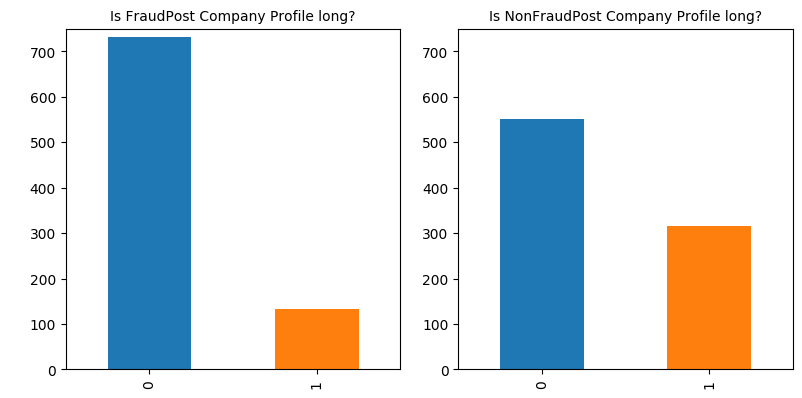

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_profile_long'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_profile_long'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Is FraudPost Company Profile long?', fontsize=10)
axes[1].set_title('Is NonFraudPost Company Profile long?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs do not have short company description 

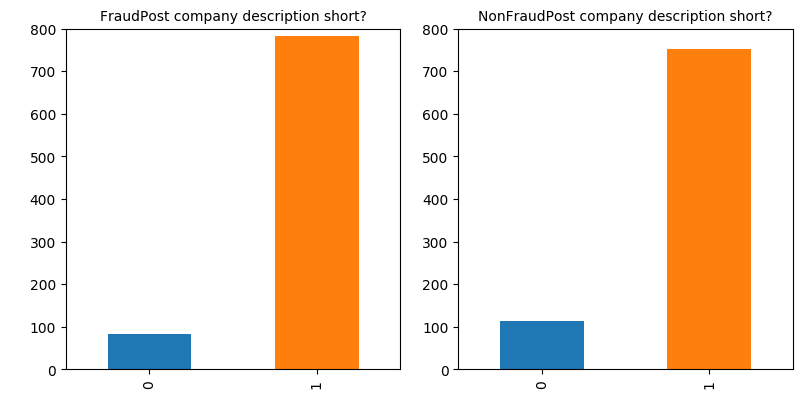

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_description_short'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_description_short'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPost company description short?', fontsize=10)
axes[1].set_title('NonFraudPost company description short?', fontsize=10)
axes[0].set_ylim([0, 800])
axes[1].set_ylim([0, 800])

plt.show()

As you can see that comparitively fraud jobs have short company description 

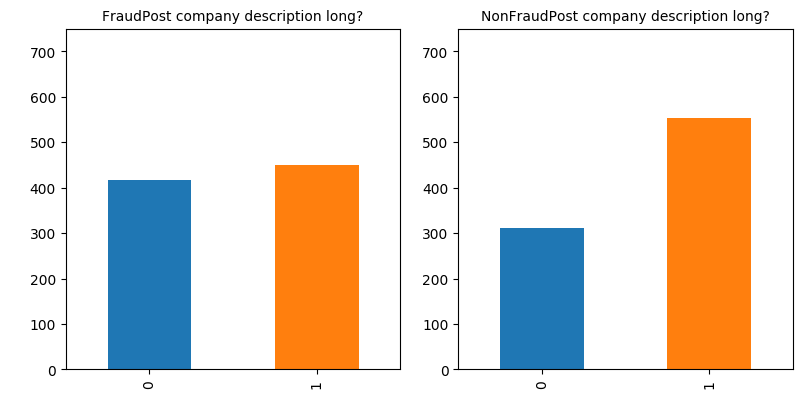

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_description_long'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_description_long'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPost company description long?', fontsize=10)
axes[1].set_title('NonFraudPost company description long?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs do not have long company description 

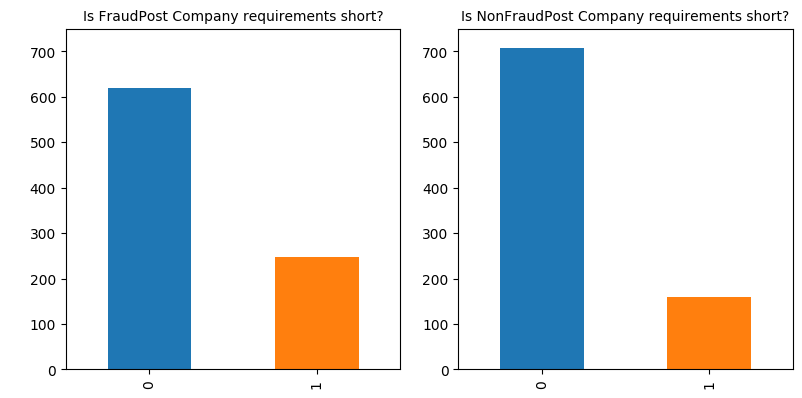

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['is_company_requirements_short'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['is_company_requirements_short'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Is FraudPost Company requirements short?', fontsize=10)
axes[1].set_title('Is NonFraudPost Company requirements short?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs have short company requirements. 

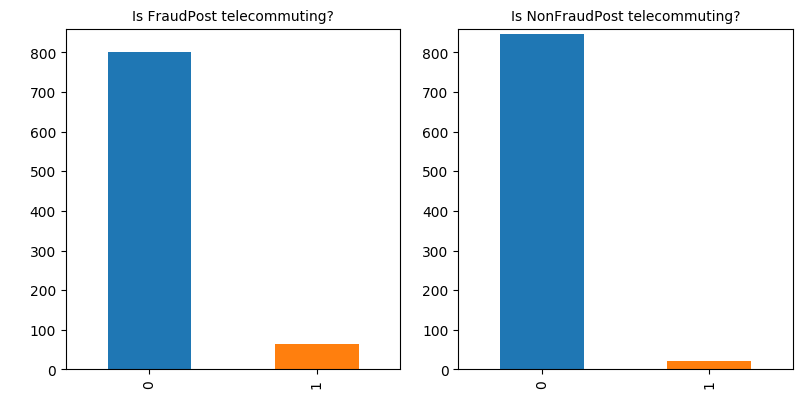

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['telecommuting'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['telecommuting'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Is FraudPost telecommuting?', fontsize=10)
axes[1].set_title('Is NonFraudPost telecommuting?', fontsize=10)
axes[0].set_ylim([0, 860])
axes[1].set_ylim([0, 860])

plt.show()

Most frauds jobs are work from home.

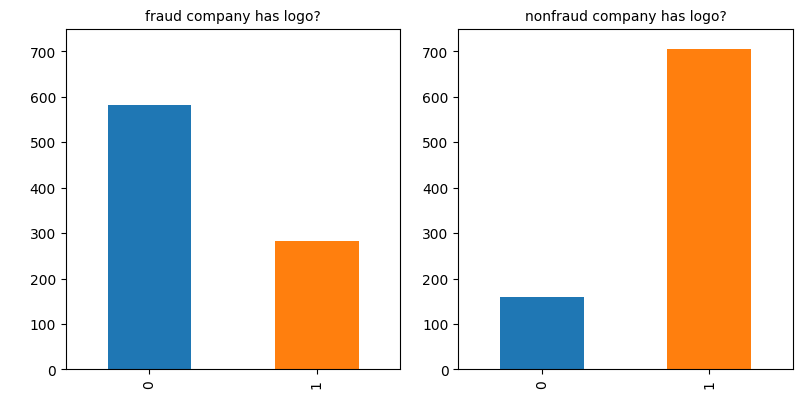

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['has_company_logo'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['has_company_logo'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('fraud company has logo?', fontsize=10)
axes[1].set_title('nonfraud company has logo?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs do not have company logo.

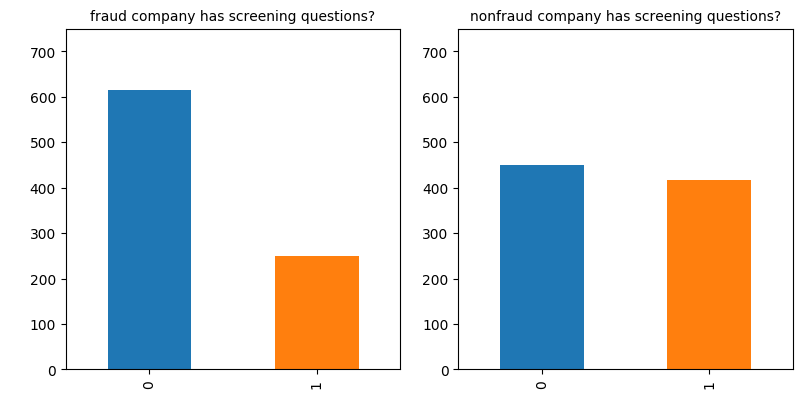

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['has_questions'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['has_questions'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('fraud company has screening questions?', fontsize=10)
axes[1].set_title('nonfraud company has screening questions?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs do not have screening questions.

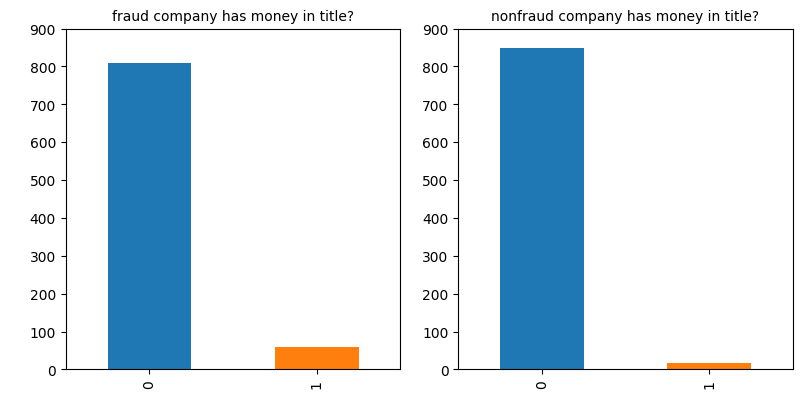

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['money_in_description'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['money_in_description'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('fraud company has money in title?', fontsize=10)
axes[1].set_title('nonfraud company has money in title?', fontsize=10)
axes[0].set_ylim([0, 900])
axes[1].set_ylim([0, 900])


plt.show()

As you can see that comparitively fraud jobs has more freqency of money in title.

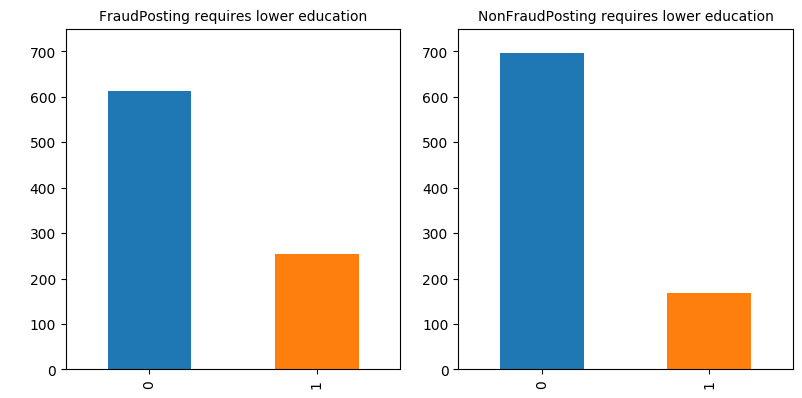

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['lower_education'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['lower_education'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPosting requires lower education', fontsize=10)
axes[1].set_title('NonFraudPosting requires lower education', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs requires lower education.

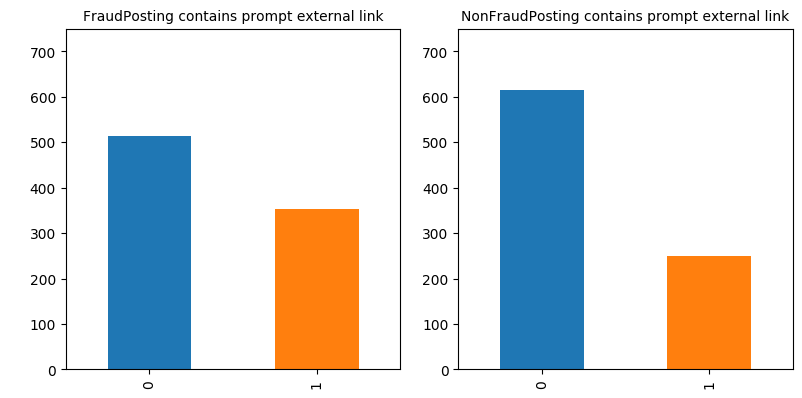

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['prompts_external_application'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['prompts_external_application'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPosting contains prompt external link', fontsize=10)
axes[1].set_title('NonFraudPosting contains prompt external link', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs freqently prompts to the external link 

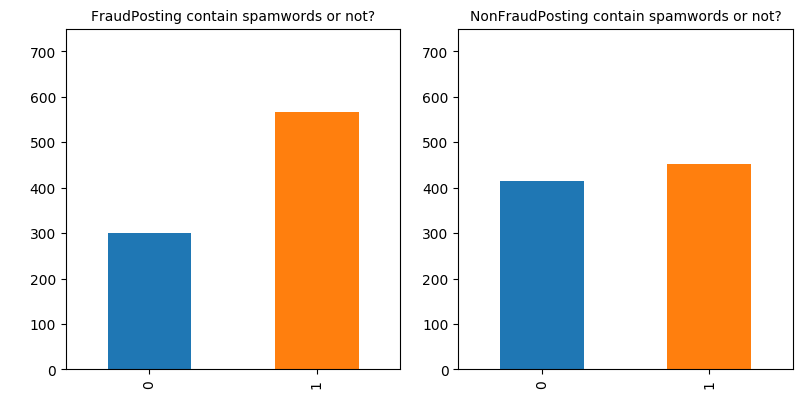

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

Fraud_Posting['spamword_list'].value_counts().sort_index().plot.bar(ax=axes[0])
SampledNonFraud_Posting['spamword_list'].value_counts().sort_index().plot.bar(ax=axes[1])

axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('FraudPosting contain spamwords or not?', fontsize=10)
axes[1].set_title('NonFraudPosting contain spamwords or not?', fontsize=10)
axes[0].set_ylim([0, 750])
axes[1].set_ylim([0, 750])

plt.show()

As you can see that comparitively fraud jobs more freqently contain spamwords.

## Pre-processing for Bag of Words
we will apply original model during model building

In [46]:
text_df = orig_df[["title", "company_profile", "description", "requirements", "benefits","fraudulent"]]
text_df = text_df.fillna(' ')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [47]:
processed_text_df = text_df[text_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1,result_type = 'expand').to_frame()
processed_text_df['fraudulent'] = text_df['fraudulent']
processed_text_df = processed_text_df.rename(columns={0:'text'})
processed_text_df.head()

,text,fraudulent
0,"Marketing Intern,We're Food52, and we've creat...",0
1,"Customer Service - Cloud Video Production,90 S...",0
2,"Commissioning Machinery Assistant (CMA),Valor ...",0
3,"Account Executive - Washington DC,Our passion ...",0
4,"Bill Review Manager,SpotSource Solutions LLC i...",0


In [48]:
data_fraud  = processed_text_df[processed_text_df['fraudulent'] == 1].copy()
data_nonfraud = processed_text_df[processed_text_df['fraudulent'] == 0].copy()

In [49]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

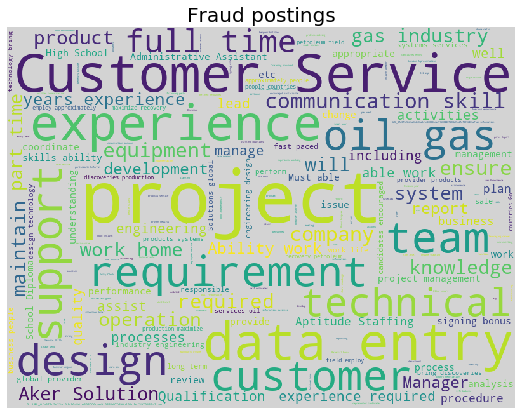

In [50]:
show_wordcloud(data_fraud, "Fraud postings")

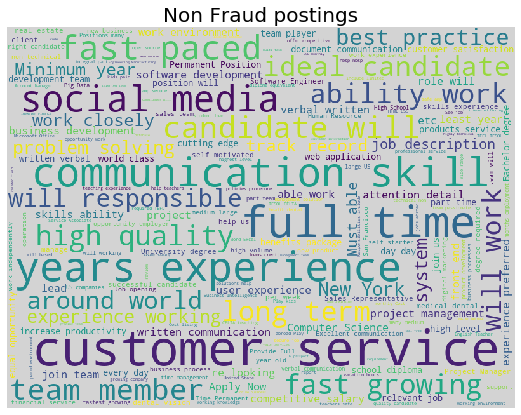

In [51]:
show_wordcloud(data_nonfraud, "Non Fraud postings")

In [52]:
def remove_punctuation_and_stopwords(text):    
    text_no_punctuation = [ch for ch in text if ch not in string.punctuation]
    text_no_punctuation = "".join(text_no_punctuation).split()
    
    text_no_punctuation_no_stopwords = [word.lower() for word in text_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return text_no_punctuation_no_stopwords

In [53]:
Final_processed_text_df = processed_text_df['text'].apply(remove_punctuation_and_stopwords)
Final_processed_text_df.head()

0    [marketing, internwere, food52, weve, created,...
1    [customer, service, cloud, video, production90...
2    [commissioning, machinery, assistant, cmavalor...
3    [account, executive, washington, dcour, passio...
4    [bill, review, managerspotsource, solutions, l...
Name: text, dtype: object

In [54]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

Final_processed_text_df = Final_processed_text_df.apply(lambda x : combine_text(x))
Final_processed_text_df.head(3)

0    marketing internwere food52 weve created groun...
1    customer service cloud video production90 seco...
2    commissioning machinery assistant cmavalor ser...
Name: text, dtype: object

In [55]:
Final_processed_text = Final_processed_text_df.to_frame()
Final_processed_text = Final_processed_text.rename(columns={0:'text'})
Final_processed_text['fraudulent'] = text_df['fraudulent']
Final_processed_text.head()

,text,fraudulent
0,marketing internwere food52 weve created groun...,0
1,customer service cloud video production90 seco...,0
2,commissioning machinery assistant cmavalor ser...,0
3,account executive washington dcour passion imp...,0
4,bill review managerspotsource solutions llc gl...,0


In [56]:
target = processed_text_df['fraudulent']

# Feature Importance

In [57]:
model_df = orig_df[["is_company_profile", "is_company_profile_short", "is_company_profile_long", "is_company_description_short", "is_company_description_long", "is_company_requirements_short", "money_in_description","telecommuting","has_company_logo","has_questions","spamword_list","prompts_external_application","lower_education","US_or_not","fraudulent"]]
Fraud_Posting_train = model_df[model_df['fraudulent']==1]
train_fraud, test_fraud = train_test_split(Fraud_Posting_train, test_size=0.2)
train_nonfraud = model_df[model_df['fraudulent']==0].sample(n=500, random_state=1)
frames = [train_fraud, train_nonfraud]
result = pd.concat(frames)
X_train = result.iloc[:, :-1]
y_train = result['fraudulent']

### Feature importance for Random Forest

Feature ranking:
1. feature is_company_profile_short (0.132351)
2. feature US_or_not (0.129978)
3. feature is_company_profile (0.124886)
4. feature has_company_logo (0.121775)
5. feature has_questions (0.079408)
6. feature prompts_external_application (0.073218)
7. feature lower_education (0.066227)
8. feature spamword_list (0.059938)
9. feature is_company_profile_long (0.050278)
10. feature is_company_description_long (0.049601)
11. feature is_company_requirements_short (0.044554)
12. feature is_company_description_short (0.032166)
13. feature telecommuting (0.020455)
14. feature money_in_description (0.015165)


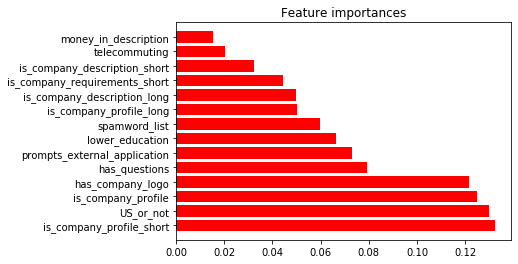

In [58]:
features = ['is_company_profile','is_company_profile_short','is_company_profile_long','is_company_description_short','is_company_description_long','is_company_requirements_short','money_in_description','telecommuting','has_company_logo','has_questions','spamword_list','prompts_external_application','lower_education','US_or_not']
forest = RandomForestClassifier(n_estimators=150)


forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]),  [features[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

### Feature importance for logistic Regression

In [69]:
# Recursive Feature Elimination
features = ['is_company_profile','is_company_profile_short','is_company_profile_long','is_company_description_short','is_company_description_long','is_company_requirements_short','money_in_description','telecommuting','has_company_logo','has_questions','spamword_list','prompts_external_application','lower_education','US_or_not']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasetsto evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 1)
rfe = rfe.fit(X_train, y_train)
print(rfe.ranking_)
print('------Ranking based on REF-------')
for f in range(X_train.shape[1]):
    print("rank is %d for feature '%s'" % (f + 1, features[rfe.ranking_[f]-1]))

[ 1  8 10 11  9 14  3  4  7 13 12  6  5  2]
------Ranking based on REF-------
rank is 1 for feature 'is_company_profile'
rank is 2 for feature 'telecommuting'
rank is 3 for feature 'has_questions'
rank is 4 for feature 'spamword_list'
rank is 5 for feature 'has_company_logo'
rank is 6 for feature 'US_or_not'
rank is 7 for feature 'is_company_profile_long'
rank is 8 for feature 'is_company_description_short'
rank is 9 for feature 'money_in_description'
rank is 10 for feature 'lower_education'
rank is 11 for feature 'prompts_external_application'
rank is 12 for feature 'is_company_requirements_short'
rank is 13 for feature 'is_company_description_long'
rank is 14 for feature 'is_company_profile_short'


# Modelling with train on Imbalance data(i.e. without sampling) and test on Imbalanced data

### Logistic Regression

In [63]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = [] 
accur_score = []
f1score = []
presc_arr = []
recl_arr = []




cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(Final_processed_text['text'], target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = Final_processed_text.iloc[train_ix]['text'], Final_processed_text.iloc[test_ix]['text']
    train_y, test_y = Final_processed_text.iloc[train_ix]['fraudulent'], Final_processed_text.iloc[test_ix]['fraudulent']

    # Appling Count Vectorizer    
    text_clf = Pipeline([('vect', CountVectorizer()),
              ('lr',  LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)),])
    
    text_clf = text_clf.fit(train_X, train_y)
    #preds = text_clf.predict(test_X)
    preds = (text_clf.predict_proba(test_X)[:,1] >= 0.7).astype(bool)
    
    
    auc = roc_auc_score(test_y, text_clf.predict_proba(test_X)[:,1])
    print('{} AUC: {}'.format(cnt, auc))
    acc_scr = accuracy_score(test_y, preds)
    print('{} Accuracy: {}'.format(cnt, acc_scr))
    f1_scr = f1_score(test_y, preds)
    print('{} f1 score: {}'.format(cnt, f1_scr))
    recl_arr = recall_score(test_y, preds)
    print('{} recall score: {}'.format(cnt, recl_arr))
    presc_arr = precision_score(test_y, preds)
    print('{} precision score: {}'.format(cnt, presc_arr))
    confmat = confusion_matrix(test_y, preds)
    print('{} confusion_matrix: {}'.format(cnt, confmat))
    auc_buf.append(auc)
    accur_score.append(acc_scr)
    f1score.append(f1_scr)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Accuracy mean score = {:.6f}'.format(np.mean(accur_score)))
print('f1 mean score = {:.6f}'.format(np.mean(f1score)))
print('recall mean score = {:.6f}'.format(np.mean(recl_arr)))
print('precision mean score = {:.6f}'.format(np.mean(presc_arr)))

Fold 1
0 AUC: 0.9835473095071623
0 Accuracy: 0.9823874755381604
0 f1 score: 0.7820069204152249
0 recall score: 0.6494252873563219
0 precision score: 0.9826086956521739
0 confusion_matrix: [[3401    2]
 [  61  113]]
Fold 2
1 AUC: 0.9810045199832178
1 Accuracy: 0.9818232662192393
1 f1 score: 0.7735191637630662
1 recall score: 0.6416184971098265
1 precision score: 0.9736842105263158
1 confusion_matrix: [[3400    3]
 [  62  111]]
Fold 3
2 AUC: 0.9736105000857793
2 Accuracy: 0.9793064876957495
2 f1 score: 0.7338129496402876
2 recall score: 0.5895953757225434
2 precision score: 0.9714285714285714
2 confusion_matrix: [[3400    3]
 [  71  102]]
Fold 4
3 AUC: 0.9730822344785882
3 Accuracy: 0.9776286353467561
3 f1 score: 0.7122302158273381
3 recall score: 0.5722543352601156
3 precision score: 0.9428571428571428
3 confusion_matrix: [[3397    6]
 [  74   99]]
Fold 5
4 AUC: 0.9871581830477142
4 Accuracy: 0.9793006993006993
4 f1 score: 0.7299270072992701
4 recall score: 0.5780346820809249
4 precisio

### MultinomialNB

In [64]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = [] 
accur_score = []
f1score = []
presc_arr = []
recl_arr = []




cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(Final_processed_text['text'], target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = Final_processed_text.iloc[train_ix]['text'], Final_processed_text.iloc[test_ix]['text']
    train_y, test_y = Final_processed_text.iloc[train_ix]['fraudulent'], Final_processed_text.iloc[test_ix]['fraudulent']

    # Appling Count Vectorizer    
    text_clf = Pipeline([('vect', CountVectorizer()),
              ('lr',  MultinomialNB()),])
    
    text_clf = text_clf.fit(train_X, train_y)
    #preds = text_clf.predict(test_X)
    preds = (text_clf.predict_proba(test_X)[:,1] >= 0.5).astype(bool)
    
    
    auc = roc_auc_score(test_y, text_clf.predict_proba(test_X)[:,1])
    print('{} AUC: {}'.format(cnt, auc))
    acc_scr = accuracy_score(test_y, preds)
    print('{} Accuracy: {}'.format(cnt, acc_scr))
    f1_scr = f1_score(test_y, preds)
    print('{} f1 score: {}'.format(cnt, f1_scr))
    recl_arr = recall_score(test_y, preds)
    print('{} recall score: {}'.format(cnt, recl_arr))
    presc_arr = precision_score(test_y, preds)
    print('{} precision score: {}'.format(cnt, presc_arr))
    confmat = confusion_matrix(test_y, preds)
    print('{} confusion_matrix: {}'.format(cnt, confmat))
    auc_buf.append(auc)
    accur_score.append(acc_scr)
    f1score.append(f1_scr)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Accuracy mean score = {:.6f}'.format(np.mean(accur_score)))
print('f1 mean score = {:.6f}'.format(np.mean(f1score)))
print('recall mean score = {:.6f}'.format(np.mean(recl_arr)))
print('precision mean score = {:.6f}'.format(np.mean(presc_arr)))

Fold 1
0 AUC: 0.9570933017182269
0 Accuracy: 0.9742801230081074
0 f1 score: 0.648854961832061
0 recall score: 0.4885057471264368
0 precision score: 0.9659090909090909
0 confusion_matrix: [[3400    3]
 [  89   85]]
Fold 2
1 AUC: 0.953991632680447
1 Accuracy: 0.9742729306487695
1 f1 score: 0.6567164179104477
1 recall score: 0.5086705202312138
1 precision score: 0.9263157894736842
1 confusion_matrix: [[3396    7]
 [  85   88]]
Fold 3
2 AUC: 0.9408036771362909
2 Accuracy: 0.9700782997762863
2 f1 score: 0.5737051792828686
2 recall score: 0.4161849710982659
2 precision score: 0.9230769230769231
2 confusion_matrix: [[3397    6]
 [ 101   72]]
Fold 4
3 AUC: 0.9377309038777413
3 Accuracy: 0.9703579418344519
3 f1 score: 0.5691056910569106
3 recall score: 0.4046242774566474
3 precision score: 0.958904109589041
3 confusion_matrix: [[3400    3]
 [ 103   70]]
Fold 5
4 AUC: 0.9578843454887128
4 Accuracy: 0.9731468531468531
4 f1 score: 0.6220472440944882
4 recall score: 0.45664739884393063
4 precision 

### DecisionTreeClassifier

In [65]:
decision_tree = DecisionTreeClassifier()

parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [10, 20, 30],
              'min_impurity_decrease': [0.00000001, 0.0000001]
             }
grid_cv = GridSearchCV(decision_tree, parameters, scoring='roc_auc')


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = [] 
accur_score = []
f1score = []
presc_arr = []
recl_arr = []

cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(Final_processed_text['text'], target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = Final_processed_text.iloc[train_ix]['text'], Final_processed_text.iloc[test_ix]['text']
    train_y, test_y = Final_processed_text.iloc[train_ix]['fraudulent'], Final_processed_text.iloc[test_ix]['fraudulent']

    # Appling Count Vectorizer    
    text_clf = Pipeline([('vect', CountVectorizer()),
              ('lr',  grid_cv),])
    
    text_clf = text_clf.fit(train_X, train_y)
    #preds = text_clf.predict(test_X)
    preds = (text_clf.predict_proba(test_X)[:,1] >= 0.5).astype(bool)
    
    
    auc = roc_auc_score(test_y, text_clf.predict_proba(test_X)[:,1])
    print('{} AUC: {}'.format(cnt, auc))
    acc_scr = accuracy_score(test_y, preds)
    print('{} Accuracy: {}'.format(cnt, acc_scr))
    f1_scr = f1_score(test_y, preds)
    print('{} f1 score: {}'.format(cnt, f1_scr))
    recl_arr = recall_score(test_y, preds)
    print('{} recall score: {}'.format(cnt, recl_arr))
    presc_arr = precision_score(test_y, preds)
    print('{} precision score: {}'.format(cnt, presc_arr))
    confmat = confusion_matrix(test_y, preds)
    print('{} confusion_matrix: {}'.format(cnt, confmat))
    auc_buf.append(auc)
    accur_score.append(acc_scr)
    f1score.append(f1_scr)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Accuracy mean score = {:.6f}'.format(np.mean(accur_score)))
print('f1 mean score = {:.6f}'.format(np.mean(f1score)))
print('recall mean score = {:.6f}'.format(np.mean(recl_arr)))
print('precision mean score = {:.6f}'.format(np.mean(presc_arr)))

Fold 1
0 AUC: 0.8913399603460097
0 Accuracy: 0.9840648588202404
0 f1 score: 0.8277945619335347
0 recall score: 0.7873563218390804
0 precision score: 0.8726114649681529
0 confusion_matrix: [[3383   20]
 [  37  137]]
Fold 2
1 AUC: 0.862897239599877
1 Accuracy: 0.9840604026845637
1 f1 score: 0.8143322475570033
1 recall score: 0.7225433526011561
1 precision score: 0.9328358208955224
1 confusion_matrix: [[3394    9]
 [  48  125]]
Fold 3
2 AUC: 0.8725070874220129
2 Accuracy: 0.9815436241610739
2 f1 score: 0.7950310559006211
2 recall score: 0.7398843930635838
2 precision score: 0.8590604026845637
2 confusion_matrix: [[3382   21]
 [  45  128]]
Fold 4
3 AUC: 0.8761905085448235
3 Accuracy: 0.982662192393736
3 f1 score: 0.8074534161490682
3 recall score: 0.7514450867052023
3 precision score: 0.87248322147651
3 confusion_matrix: [[3384   19]
 [  43  130]]
Fold 5
4 AUC: 0.8733514457663462
4 Accuracy: 0.9823776223776224
4 f1 score: 0.8025078369905955
4 recall score: 0.7398843930635838
4 precision sc

## Random Forest

In [66]:
random_forest = RandomForestClassifier()


parameters = {'n_estimators': [150,250], 
              'criterion': ['entropy', 'gini'],
              'min_samples_split': [10, 20, 30],
              'min_impurity_decrease': [0.00000001, 0.0000001]
             }

grid_cv = GridSearchCV(random_forest, parameters, scoring='roc_auc')

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = [] 
accur_score = []
f1score = []
presc_arr = []
recl_arr = []

cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(Final_processed_text['text'], target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = Final_processed_text.iloc[train_ix]['text'], Final_processed_text.iloc[test_ix]['text']
    train_y, test_y = Final_processed_text.iloc[train_ix]['fraudulent'], Final_processed_text.iloc[test_ix]['fraudulent']

    # Appling Count Vectorizer   
    text_clf = Pipeline([('vect', CountVectorizer()),
              ('lr',  RandomForestClassifier(n_estimators=250)),])
    #text_clf = Pipeline([('vect', CountVectorizer()),('lr',  grid_cv),])
    
    text_clf = text_clf.fit(train_X, train_y)
    #preds = text_clf.predict(test_X)
    preds = (text_clf.predict_proba(test_X)[:,1] >= 0.5).astype(bool)
    
    
    auc = roc_auc_score(test_y, text_clf.predict_proba(test_X)[:,1])
    print('{} AUC: {}'.format(cnt, auc))
    acc_scr = accuracy_score(test_y, preds)
    print('{} Accuracy: {}'.format(cnt, acc_scr))
    f1_scr = f1_score(test_y, preds)
    print('{} f1 score: {}'.format(cnt, f1_scr))
    recl_arr = recall_score(test_y, preds)
    print('{} recall score: {}'.format(cnt, recl_arr))
    presc_arr = precision_score(test_y, preds)
    print('{} precision score: {}'.format(cnt, presc_arr))
    confmat = confusion_matrix(test_y, preds)
    print('{} confusion_matrix: {}'.format(cnt, confmat))
    auc_buf.append(auc)
    accur_score.append(acc_scr)
    f1score.append(f1_scr)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Accuracy mean score = {:.6f}'.format(np.mean(accur_score)))
print('f1 mean score = {:.6f}'.format(np.mean(f1score)))
print('recall mean score = {:.6f}'.format(np.mean(recl_arr)))
print('precision mean score = {:.6f}'.format(np.mean(presc_arr)))

Fold 1
0 AUC: 0.9882363769628557
0 Accuracy: 0.9854626782219738
0 f1 score: 0.8255033557046979
0 recall score: 0.7068965517241379
0 precision score: 0.9919354838709677
0 confusion_matrix: [[3402    1]
 [  51  123]]
Fold 2
1 AUC: 0.9904071382102497
1 Accuracy: 0.982662192393736
1 f1 score: 0.7832167832167832
1 recall score: 0.6473988439306358
1 precision score: 0.9911504424778761
1 confusion_matrix: [[3402    1]
 [  61  112]]
Fold 3
2 AUC: 0.9850454970877447
2 Accuracy: 0.9818232662192393
2 f1 score: 0.7686832740213524
2 recall score: 0.6242774566473989
2 precision score: 1.0
2 confusion_matrix: [[3403    0]
 [  65  108]]
Fold 4
3 AUC: 0.9807361406715258
3 Accuracy: 0.9821029082774049
3 f1 score: 0.7730496453900709
3 recall score: 0.630057803468208
3 precision score: 1.0
3 confusion_matrix: [[3403    0]
 [  64  109]]
Fold 5
4 AUC: 0.9860070410809011
4 Accuracy: 0.9815384615384616
4 f1 score: 0.7659574468085106
4 recall score: 0.6242774566473989
4 precision score: 0.9908256880733946
4 co

## Gradient Boosting
gridsearchcv was taking lot of time on gradientboosting, hence didnt try

In [67]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
auc_buf = [] 
accur_score = []
f1score = []
presc_arr = []
recl_arr = []




cnt = 0
predictions = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(Final_processed_text['text'], target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = Final_processed_text.iloc[train_ix]['text'], Final_processed_text.iloc[test_ix]['text']
    train_y, test_y = Final_processed_text.iloc[train_ix]['fraudulent'], Final_processed_text.iloc[test_ix]['fraudulent']

    # Appling Count Vectorizer    
    text_clf = Pipeline([('vect', CountVectorizer()),
              ('lr',  GradientBoostingClassifier(n_estimators=150)),])
    
    text_clf = text_clf.fit(train_X, train_y)
    preds = (text_clf.predict_proba(test_X)[:,1] >= 0.5).astype(bool)
    
    
    auc = roc_auc_score(test_y, text_clf.predict_proba(test_X)[:,1])
    print('{} AUC: {}'.format(cnt, auc))
    acc_scr = accuracy_score(test_y, preds)
    print('{} Accuracy: {}'.format(cnt, acc_scr))
    f1_scr = f1_score(test_y, preds)
    print('{} f1 score: {}'.format(cnt, f1_scr))
    recl_arr = recall_score(test_y, preds)
    print('{} recall score: {}'.format(cnt, recl_arr))
    presc_arr = precision_score(test_y, preds)
    print('{} precision score: {}'.format(cnt, presc_arr))
    confmat = confusion_matrix(test_y, preds)
    print('{} confusion_matrix: {}'.format(cnt, confmat))
    auc_buf.append(auc)
    accur_score.append(acc_scr)
    f1score.append(f1_scr)
    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('Accuracy mean score = {:.6f}'.format(np.mean(accur_score)))
print('f1 mean score = {:.6f}'.format(np.mean(f1score)))
print('recall mean score = {:.6f}'.format(np.mean(recl_arr)))
print('precision mean score = {:.6f}'.format(np.mean(presc_arr)))

Fold 1
0 AUC: 0.955273575378047
0 Accuracy: 0.9815487838971205
0 f1 score: 0.7770270270270271
0 recall score: 0.6609195402298851
0 precision score: 0.9426229508196722
0 confusion_matrix: [[3396    7]
 [  59  115]]
Fold 2
1 AUC: 0.9587553654629798
1 Accuracy: 0.9829418344519015
1 f1 score: 0.7874564459930313
1 recall score: 0.653179190751445
1 precision score: 0.9912280701754386
1 confusion_matrix: [[3402    1]
 [  60  113]]
Fold 3
2 AUC: 0.9576283422141972
2 Accuracy: 0.9804250559284117
2 f1 score: 0.75177304964539
2 recall score: 0.6127167630057804
2 precision score: 0.9724770642201835
2 confusion_matrix: [[3400    3]
 [  67  106]]
Fold 4
3 AUC: 0.9270118681408278
3 Accuracy: 0.9801454138702461
3 f1 score: 0.7455197132616488
3 recall score: 0.6011560693641619
3 precision score: 0.9811320754716981
3 confusion_matrix: [[3401    2]
 [  69  104]]
Fold 5
4 AUC: 0.947822260282119
4 Accuracy: 0.9801398601398601
4 f1 score: 0.7526132404181185
4 recall score: 0.6242774566473989
4 precision sco

# Modelling with train on balanced data(i.e. sampling) and test on Imbalanced data

In [70]:
model_df_x = Final_processed_text['text']
model_df_y = Final_processed_text['fraudulent']
train_fraud, test_fraud, train_fraud_y, test_fraud_y = train_test_split(model_df_x,model_df_y, test_size=0.2,random_state=123, stratify=model_df_y.values)

In [71]:
train_fraud = train_fraud.to_frame()
train_fraud['fraudulent'] = train_fraud_y.to_frame()

In [72]:
test_fraud = test_fraud.to_frame()
test_fraud['fraudulent'] = test_fraud_y.to_frame()

In [73]:
Fraud_Posting = train_fraud[train_fraud['fraudulent']==1]
SampledNonFraud_Posting = train_fraud[train_fraud['fraudulent']==0].sample(n=693, random_state=1)
frames = [Fraud_Posting, SampledNonFraud_Posting]
train_fraud = pd.concat(frames)

In [74]:
train_fraud.fraudulent.value_counts()

1    693
0    693
Name: fraudulent, dtype: int64

In [75]:
test_fraud.fraudulent.value_counts()

0    3403
1     173
Name: fraudulent, dtype: int64

In [87]:
text_clf = Pipeline([('vect', CountVectorizer()),
          ('lr',  LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=0, n_jobs=-1)),])
text_clf = text_clf.fit(train_fraud['text'], train_fraud['fraudulent'])
preds = (text_clf.predict_proba(test_fraud['text'])[:,1] >= 0.98).astype(bool)

auc = roc_auc_score(test_fraud['fraudulent'], text_clf.predict_proba(test_fraud['text'])[:,1])
print('auc', auc)
f1_scr = f1_score(test_fraud['fraudulent'], preds)
print('f1 score', f1_scr)
presc = precision_score(test_fraud['fraudulent'], preds)
print('precision_score', presc)
recl = recall_score(test_fraud['fraudulent'], preds)
print('recall_score', recl)
acc_scr = accuracy_score(test_fraud['fraudulent'], preds)
print('acc_scr', acc_scr)
confmat = confusion_matrix(test_fraud['fraudulent'], preds)
print('confmat', confmat)
clf_report = classification_report(test_fraud['fraudulent'], preds)
print('clf_report', clf_report)

auc 0.9698905589933398
f1 score 0.4789915966386554
precision_score 0.8769230769230769
recall_score 0.32947976878612717
acc_scr 0.9653243847874721
confmat [[3395    8]
 [ 116   57]]
clf_report              precision    recall  f1-score   support

          0       0.97      1.00      0.98      3403
          1       0.88      0.33      0.48       173

avg / total       0.96      0.97      0.96      3576



In [91]:
text_clf = Pipeline([('vect', CountVectorizer()),
          ('lr',  MultinomialNB()),])
text_clf = text_clf.fit(train_fraud['text'], train_fraud['fraudulent'])
preds = (text_clf.predict_proba(test_fraud['text'])[:,1] >= 0.98).astype(bool)

auc = roc_auc_score(test_fraud['fraudulent'], text_clf.predict_proba(test_fraud['text'])[:,1])
print('auc', auc)
f1_scr = f1_score(test_fraud['fraudulent'], preds)
print('f1 score', f1_scr)
presc = precision_score(test_fraud['fraudulent'], preds)
print('precision_score', presc)
recl = recall_score(test_fraud['fraudulent'], preds)
print('recall_score', recl)
acc_scr = accuracy_score(test_fraud['fraudulent'], preds)
print('acc_scr', acc_scr)
confmat = confusion_matrix(test_fraud['fraudulent'], preds)
print('confmat', confmat)
clf_report = classification_report(test_fraud['fraudulent'], preds)
print('clf_report', clf_report)

auc 0.9603996133979029
f1 score 0.5026178010471205
precision_score 0.36
recall_score 0.8323699421965318
acc_scr 0.9203020134228188
confmat [[3147  256]
 [  29  144]]
clf_report              precision    recall  f1-score   support

          0       0.99      0.92      0.96      3403
          1       0.36      0.83      0.50       173

avg / total       0.96      0.92      0.93      3576



In [95]:
decision_tree = DecisionTreeClassifier()

parameters = {'criterion': ['entropy', 'gini'],
              'min_samples_split': [5, 10, 20, 30, 40],
              'min_impurity_decrease': [0.00000001, 0.0000001]
             }
grid_cv = GridSearchCV(decision_tree, parameters, scoring='roc_auc')

text_clf = Pipeline([('vect', CountVectorizer()),
          ('lr',  grid_cv),])
text_clf = text_clf.fit(train_fraud['text'], train_fraud['fraudulent'])
preds = (text_clf.predict_proba(test_fraud['text'])[:,1] >= 0.98).astype(bool)

auc = roc_auc_score(test_fraud['fraudulent'], text_clf.predict_proba(test_fraud['text'])[:,1])
print('auc', auc)
f1_scr = f1_score(test_fraud['fraudulent'], preds)
print('f1 score', f1_scr)
presc = precision_score(test_fraud['fraudulent'], preds)
print('precision_score', presc)
recl = recall_score(test_fraud['fraudulent'], preds)
print('recall_score', recl)
acc_scr = accuracy_score(test_fraud['fraudulent'], preds)
print('acc_scr', acc_scr)
confmat = confusion_matrix(test_fraud['fraudulent'], preds)
print('confmat', confmat)
clf_report = classification_report(test_fraud['fraudulent'], preds)
print('clf_report', clf_report)

auc 0.8608317380617918
f1 score 0.3739130434782609
precision_score 0.2495164410058027
recall_score 0.7456647398843931
acc_scr 0.8791946308724832
confmat [[3015  388]
 [  44  129]]
clf_report              precision    recall  f1-score   support

          0       0.99      0.89      0.93      3403
          1       0.25      0.75      0.37       173

avg / total       0.95      0.88      0.91      3576



In [96]:
random_forest = RandomForestClassifier()

parameters = {'n_estimators': [300,500], 
              'criterion': ['entropy', 'gini']
             }
grid_cv = GridSearchCV(random_forest, parameters, scoring='roc_auc')

text_clf = Pipeline([('vect', CountVectorizer()),
          ('lr',  grid_cv),])
text_clf = text_clf.fit(train_fraud['text'], train_fraud['fraudulent'])
preds = (text_clf.predict_proba(test_fraud['text'])[:,1] >= 0.98).astype(bool)

auc = roc_auc_score(test_fraud['fraudulent'], text_clf.predict_proba(test_fraud['text'])[:,1])
print('auc', auc)
f1_scr = f1_score(test_fraud['fraudulent'], preds)
print('f1 score', f1_scr)
presc = precision_score(test_fraud['fraudulent'], preds)
print('precision_score', presc)
recl = recall_score(test_fraud['fraudulent'], preds)
print('recall_score', recl)
acc_scr = accuracy_score(test_fraud['fraudulent'], preds)
print('acc_scr', acc_scr)
confmat = confusion_matrix(test_fraud['fraudulent'], preds)
print('confmat', confmat)
clf_report = classification_report(test_fraud['fraudulent'], preds)
print('clf_report', clf_report)

auc 0.9715271632136895
f1 score 0.46017699115044247
precision_score 0.9811320754716981
recall_score 0.30057803468208094
acc_scr 0.9658836689038032
confmat [[3402    1]
 [ 121   52]]
clf_report              precision    recall  f1-score   support

          0       0.97      1.00      0.98      3403
          1       0.98      0.30      0.46       173

avg / total       0.97      0.97      0.96      3576



In [98]:
text_clf = Pipeline([('vect', CountVectorizer()),
          ('lr',  GradientBoostingClassifier(n_estimators=150)),])
text_clf = text_clf.fit(train_fraud['text'], train_fraud['fraudulent'])
preds = (text_clf.predict_proba(test_fraud['text'])[:,1] >= 0.90).astype(bool)

auc = roc_auc_score(test_fraud['fraudulent'], text_clf.predict_proba(test_fraud['text'])[:,1])
print('auc', auc)
f1_scr = f1_score(test_fraud['fraudulent'], preds)
print('f1 score', f1_scr)
presc = precision_score(test_fraud['fraudulent'], preds)
print('precision_score', presc)
recl = recall_score(test_fraud['fraudulent'], preds)
print('recall_score', recl)
acc_scr = accuracy_score(test_fraud['fraudulent'], preds)
print('acc_scr', acc_scr)
confmat = confusion_matrix(test_fraud['fraudulent'], preds)
print('confmat', confmat)
clf_report = classification_report(test_fraud['fraudulent'], preds)
print('clf_report', clf_report)

auc 0.9583689332262081
f1 score 0.5461847389558232
precision_score 0.8947368421052632
recall_score 0.3930635838150289
acc_scr 0.968400447427293
confmat [[3395    8]
 [ 105   68]]
clf_report              precision    recall  f1-score   support

          0       0.97      1.00      0.98      3403
          1       0.89      0.39      0.55       173

avg / total       0.97      0.97      0.96      3576

